**Convolutional Neural Network (CNN) -  Digit Recognition - MNIS**


Masalah klasifikasi digit tulisan tangan MNIST adalah kumpulan data standar yang digunakan dalam computer vision dan deep learning.

Meskipun dataset dapat dipecahkan secara efektif, namun dapat digunakan sebagai dasar untuk mempelajari dan mempraktikkan cara mengembangkan, mengevaluasi, dan menggunakan Convolutional Neural Network Deep Learning untuk klasifikasi gambar dari awal. Mncakup cara mengembangkan rangkaian uji yang kuat untuk memperkirakan kinerja model, cara mengeksplorasi peningkatan model, dan cara menyimpan model dan kemudian memuatnya untuk membuat prediksi pada data baru.


Dataset MNIST merupakan kumpulan data yang terdiri dari 60.000 gambar skala abu-abu 28x28 piksel persegi kecil dari 10 tulisan tangan yang mewakili nilai 0 hingga 9. Berikut adalah contoh gambahr tulisan tangan dataset MINST.

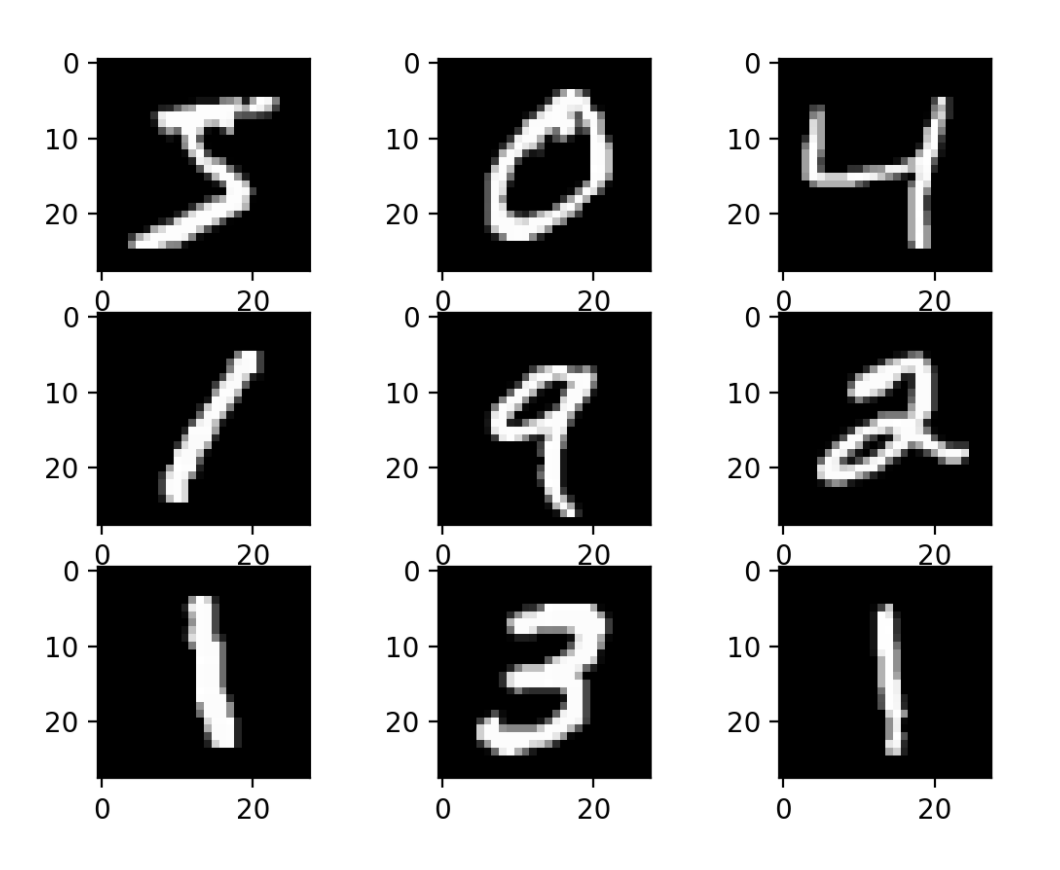


Urutan contoh program CNN untuk digit recognation yang akan dibahas terdiri dari beberapa bagian, yaitu :
1.   Inisialisasi Libraries (Import)
2.   Load Dataset
3.   Scale Pixel
4.   Model CNN
5.   Evaluasi Model
6.   Hasil (Visualisasi)
  *  Kurva Pembelajaran Diagnostik
  *  Kesimpulan performansi Model  

    
**Inisialisasi Libraries (Import)**

Librari yang digunakan meliputi beberapa librasi standar serta librari tensorflow. Librari tensorflow memudahkan kita untuk melakukan pengkodean secara cepat fungsi serta pemanggilan dataset (dataset fashion_minst, fungsi Dense layer, fungsi optimizer, dll)

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

**Load Dataset**

Dataset fashion_mnist berisi semua gambar telah disegmentasi sebelumnya (misalnya setiap gambar berisi satu item pakaian), semua gambar memiliki ukuran persegi yang sama yaitu 28x28 piksel, dan bahwa gambar tersebut skala abu-abu. Oleh karena itu, kita dapat memuat gambar dan membentuk kembali array data untuk memiliki saluran warna tunggal.

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	
	# reshape dataset untuk mendapatkan single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	
	# one hot encode nilai-nilai target
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

**Scale Pixels**


Nilai piksel untuk setiap gambar dalam kumpulan data adalah bilangan bulat, dalam kisaran antara hitam dan putih (bernilai antara 0 dan 255).

Titik awal yang baik adalah menormalkan nilai piksel gambar skala abu-abu, (misal ubah skalanya ke kisaran [0,1]). Ini melibatkan pertama-tama mengubah tipe data dari bilangan bulat yang tidak ditandatangani ke float, kemudian membagi nilai piksel dengan nilai maksimum (nilai 255).

In [ ]:
# men-skala-kan pixels
def prep_pixels(train, test):
	
	# mengubah tipe data variabel train_norm dan test_norm dari integers menjadi floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	
	# normalize menjadi angka antara 0-1 (float)
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0

	# return gambar yang telah di-normalisasi
	return train_norm, test_norm

**Model CNN**

Model memiliki dua aspek utama: front end ekstraksi fitur yang terdiri dari lapisan convolutional dan pooling, dan backend classifier yang akan membuat prediksi. Untuk front-end convolutional dilakukan dengan satu convolutional layer dengan ukuran filter kecil (3,3) dan sejumlah filter (32) diikuti dengan max pooling layer. Peta filter kemudian dapat diratakan untuk memberikan fitur ke pengklasifikasi.

Berdasarkan permasalahan yang termasuk klasifikasi multi-kelas, kebutuhan lapisan keluaran dengan 10 node untuk memprediksi distribusi probabilitas dari sebuah gambar milik masing-masing dari 10 kelas. Model yang dibangun juga akan memerlukan penggunaan fungsi aktivasi softmax. Di antara ekstraktor fitur dan lapisan keluaran, kita dapat menambahkan lapisan padat untuk menginterpretasikan fitur, dalam hal ini dengan 100 node. Semua lapisan akan menggunakan fungsi aktivasi ReLU dan skema inisialisasi bobot, keduanya merupakan praktik terbaik.

Konfigurasi konservatif digunakan untuk pengoptimal penurunan gradien stokastik dengan tingkat pembelajaran 0,01 dan momentum 0,9. Fungsi cross-entropy loss akan dioptimalkan.

In [ ]:
# Model CNN 
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	
	# proses compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

**Evaluasi Model**

Evaluasi model perlu dilakukan setelah proses pendefinisan model. Model akan dievaluasi menggunakan validasi silang 5 kali lipat. Nilai k=5 dipilih untuk memberikan dasar untuk evaluasi berulang dan tidak terlalu besar untuk membutuhkan waktu yang lama. Setiap set pengujian akan menjadi 20% dari set data pelatihan, atau sekitar 12.000 contoh, mendekati ukuran set pengujian yang sebenarnya untuk masalah ini.

Kumpulan data pelatihan dikocok sebelum dipecah dan pengacakan sampel dilakukan setiap kali sehingga model apa pun yang dievaluasi akan memiliki kumpulan data latih dan uji yang sama di setiap lipatan, memberikan perbandingan apel-ke-apel.

Melatih model dasar untuk 10 periode pelatihan sederhana dengan ukuran batch default 32. Test set untuk setiap fold akan digunakan untuk mengevaluasi model baik pada setiap epoch run pelatihan, sehingga nantinya kita dapat membuat kurva pembelajaran, sehingga kita dapat memperkirakan kinerja model. Karena itu, pelacakan riwayat yang dihasilkan dari setiap putaran, serta akurasi klasifikasi lipatan.

Fungsi evaluate_model() di bawah ini mengimplementasikan perilaku tersebut diatas, mengambil set data pelatihan sebagai argumen dan mengembalikan daftar skor akurasi dan riwayat pelatihan yang dapat diringkas nanti.

In [ ]:
# evaluate model menggunakan k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		
		# evaluasi model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		
		# tambah/sisipkan scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

**Hasil**

Ada dua aspek kunci untuk disajikan: diagnostik perilaku belajar model selama pelatihan dan estimasi kinerja model. Ini dapat diimplementasikan menggunakan fungsi terpisah.

Pertama, diagnostik melibatkan pembuatan plot garis yang menunjukkan kinerja model pada rangkaian pelatihan dan pengujian selama setiap lipatan validasi silang k-fold. Plot-plot ini berharga untuk mendapatkan gambaran apakah model overfitting, underfitting, atau fit/cocok untuk dataset.


**Kurva Pembelajaran Diagnostik**

In [ ]:
# plot kurva pembelajaran diagnostik
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		
		# plot loss
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		
		# plot akurasi
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

**Kesimpulan Performansi Model**

In [ ]:
# fungsi kesimpulan performasi model
def summarize_performance(scores):
	
	# cetak kesimpulan
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	
	# box and whisker plots dari hasil
	pyplot.boxplot(scores)
	pyplot.show()

**Menjalankan Program**

Setelah inisialisasi dan beberapa fungsi diatas telah dibuat, makan fungsi run_test_harness dibuat untuk memanggil fungsi-fungsi program diatas secata runut. Dimulai dengan memanggil dataset, menskalakan pixel, menjalankan proses training serta evaluasi model hingga menampilkan hasil dalam bentuk kurva pembelajaran diagnistik serta kesimpulan performansi model.

In [ ]:
# Funsi menjalankan program untuk mengevaluasi model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	
	# pixel data
	trainX, testX = prep_pixels(trainX, testX)
	
	# evaluasi model
	scores, histories = evaluate_model(trainX, trainY)

	# kurva pembelajaran
	summarize_diagnostics(histories)
	
	# kesimpulan estimasi performansi
	summarize_performance(scores)
 
# Jalanjkan program dengan memanggil fungsi run_test_harness()
run_test_harness()

**Visualisasi Hasil**

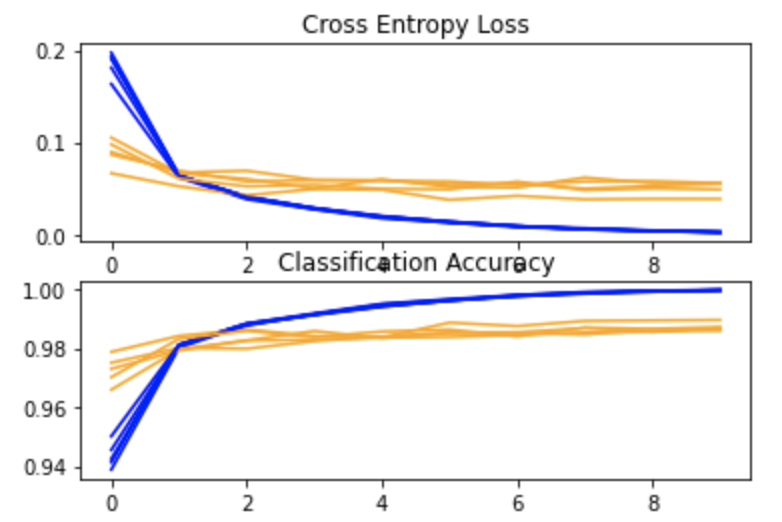

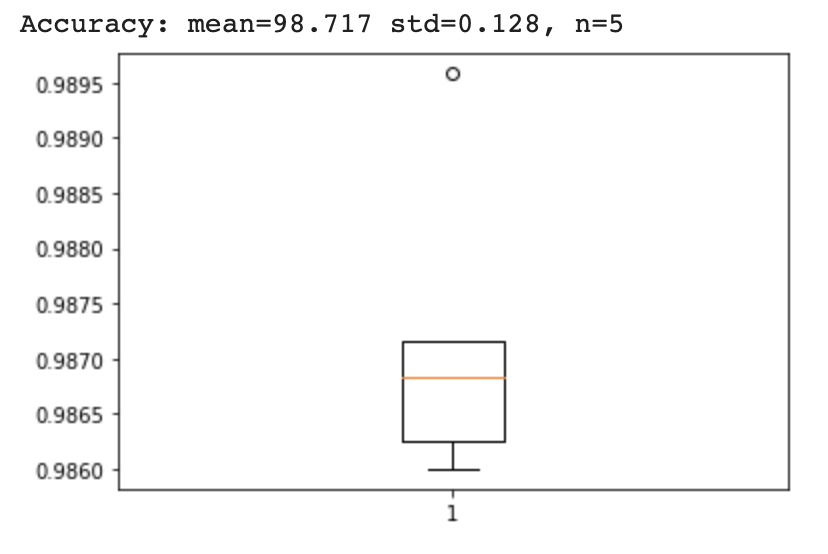